# <center>Team 5 - Final Project</center>
## <center>DATA 620 - Web Analytics - Summer 2018</center>
## <center>Final Project</center>
### Christopher Estevez, Meaghan Burke, Rickidon Singh,  Ritesh Lohiya, Rose Koh

### @jimmyfallon: A Twitter Sentiment and Network Analysis

#### Introduction:

Jimmy Fallon is a comedian known for his work on Saturday Night Live and as the host of late-night talk show The Tonight Show Starring Jimmy Fallon. Jimmy Fallon's Twitter handle, **@jimmyfallon**, is the 20th most followed account on twitter with 50.2 million followers. For the final project, team 5 will employ Data 620 concepts to understand the overall tweet sentiment and social network influence of a **@jimmyfallon**.  

#### Hypothesis:
- Team 5 is expecting the tweet sentiment analysis for **@jimmyfallon** to be mostly positive due to his occupation as a comedian 
- Due to the size of his follower network and celebrity status, Team 5 is anticipating **@jimmyfallon** to have a relatively large influence

#### Steps:

    1) Mining Twitter
    2) Convert the json object to a pandas dataframe
    3) Text Frequency
    4) Sentiment Analysis
    6) Network Analysis


In [188]:
!python --version
#https://stackoverflow.com/questions/34168019/how-to-use-3to2

Python 2.7.14 :: Anaconda custom (64-bit)


### 1) Mining Twitter

#### 1.1) Authorizing an application for access to twitter 

In [189]:
from tw_cred import * # import your own credential
import tweepy

consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

####  1.2) Get @jimmyfallon tweet data using api.user_timeline()


In [190]:
import sys
import jsonpickle
import os

searchQuery = '@jimmyfallon' #'#someHashtag'  # this is what we're searching for
maxTweets = 10000# Some arbitrary large number
tweetsPerQry = 100 # this is the max the API permits
fName = './data/tweets.txt' # We'll store the tweets in a text file..


# If results from a specific ID onwards are reqd, set since_id to that ID.
# else default to no lower limit, go as far back as API allows
sinceId = None

# If results only below a specific ID are, set max_id to that ID.
# else default to no upper limit, start from the most recent tweet matching the search query.
max_id=-1
tweetCount = 0
#print("Downloading max {0} tweets".format(maxTweets))
with open(fName, 'w') as f:
    while tweetCount < maxTweets:
        try:
            if (max_id <= 0):
                if (not sinceId):
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False,
                                count=tweetsPerQry)
                else:
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False,
                                count=tweetsPerQry,
                                max_id=str(max_id - 1),
                                since_id=sinceId)
            else:
                if (not sinceId):
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False, 
                                count=tweetsPerQry,
                                max_id=str(max_id - 1))
                else:
                    new_tweets = api.user_timeline(screen_name = searchQuery, # user_id=tweeters,
                                include_rts=True,
                                exclude_replies =False, count=tweetsPerQry,
                                            max_id=str(max_id - 1),
                                            since_id=sinceId)
            if not new_tweets:
                #print("No more tweets found")
                break
            for tweet in new_tweets:
                f.write(jsonpickle.encode(tweet._json, unpicklable=False) +
                        '\n')
            tweetCount += len(new_tweets)
            #print("Downloaded {0} tweets".format(tweetCount))
            max_id = new_tweets[-1].id
        except tweepy.TweepError as e:
            # Just exit if any error
            print("some error : " + str(e))
            break

#### 1.3) Store tweets in a json object 
- load the json tweet data 
- Preliminary exploratory analysis of the json object 
   - Total tweets = 3,222
   - Print sample json object  
- Twitter stores tweet and user metadata such as user name, ID, creation date, user location, the number of re-tweets, etc.  This expansive data coverage will help team 5 understand the Twitter user's network and to measure **@jimmyfallon** relative influence within the network. 


In [191]:
import json
import pandas as pd

In [192]:
tweets_data_path = './data/tweets.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

In [193]:
print(len(tweets_data))

3222


In [194]:
tweets_data[2]

{u'contributors': None,
 u'coordinates': None,
 u'created_at': u'Sun Jul 08 15:09:06 +0000 2018',
 u'entities': {u'hashtags': [{u'indices': [50, 73],
    u'text': u'TonightShowSummerReads'}],
  u'symbols': [],
  u'urls': [],
  u'user_mentions': []},
 u'favorite_count': 755,
 u'favorited': False,
 u'geo': None,
 u'id': 1015976073576804352L,
 u'id_str': u'1015976073576804352',
 u'in_reply_to_screen_name': u'jimmyfallon',
 u'in_reply_to_status_id': 1015975660890796032L,
 u'in_reply_to_status_id_str': u'1015975660890796032',
 u'in_reply_to_user_id': 15485441,
 u'in_reply_to_user_id_str': u'15485441',
 u'is_quote_status': False,
 u'lang': u'en',
 u'place': None,
 u'retweet_count': 84,
 u'retweeted': False,
 u'source': u'<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
 u'text': u'And share photos of where you are reading and use #TonightShowSummerReads!!',
 u'truncated': False,
 u'user': {u'contributors_enabled': False,
  u'created_at': u'Fri Jul 18 19:46:50 +0000 2008',

### 2) Data Preprocessing

#### 2.1 ) Convert Json Objects
- Add applicable data for sentiment analysis 
    - time stamp, name, Tweet text, language, Tweet id, favorites number, retweets number, in_reply_to_status_id_str and in_reply_to_screen_name

In [195]:
tweets = pd.DataFrame() #create pandas dataframe
tweets['TimeStamp'] = list(map(lambda tweet: tweet['created_at'], tweets_data))
tweets['Name'] = list(map(lambda tweet: tweet["user"]["screen_name"], tweets_data))
tweets['text'] = list(map(lambda tweet: tweet['text'], tweets_data))
tweets['lang'] = list(map(lambda tweet: tweet['lang'], tweets_data))
tweets['tweet_id'] = list(map(lambda tweet: tweet['id'], tweets_data))
tweets['Favorites'] = list(map(lambda tweet: tweet['favorite_count'], tweets_data))
tweets['Retweet'] = list(map(lambda tweet: tweet['retweet_count'], tweets_data))
tweets['in_reply_to_status_id_str'] = list(map(lambda tweet: tweet['in_reply_to_status_id_str'], tweets_data))
tweets['in_reply_to_screen_name'] = list(map(lambda tweet: tweet['in_reply_to_screen_name'], tweets_data))

In [196]:
tweets.head(1)

,TimeStamp,Name,text,lang,tweet_id,Favorites,Retweet,in_reply_to_status_id_str,in_reply_to_screen_name
0,Tue Jul 17 01:54:48 +0000 2018,jimmyfallon,RT @FallonTonight: Great way to start a week o...,en,1019037671295979520,0,92,None,None


#### 2.2) Data Cleaning
- Extract the username through the tweets, if applicable 
- Remove the URLs, RTs, and twitter handles from the tweet text
- Remove specific punctuation 
- Cast to lowercase and delete the double space with the function apply

In [197]:
%%time

pd.options.mode.chained_assignment = None

#extract the username through the tweets (preceded by @ or by RT @)
tweets['tweetos'] = '' 

#add tweetos first part
for i in range(len(tweets['text'])):
    try:
        tweets['tweetos'][i] = tweets['text'].str.split(' ')[i][0]
    except AttributeError:    
        tweets['tweetos'][i] = 'other'

#Preprocessing tweetos. select tweetos contains 'RT @'
for i in range(len(tweets['text'])):
    if tweets['tweetos'].str.contains('@')[i]  == False:
        tweets['tweetos'][i] = 'other'
        
# remove URLs, RTs, and twitter handles
for i in range(len(tweets['text'])):
    tweets['text'][i] = " ".join([word for word in tweets['text'][i].split()
                                if 'http' not in word and '@' not in word and '<' not in word])

Wall time: 35.2 s


In [198]:
tweets['text'][0]

u'RT Great way to start a week of new shows with and Plus, Charades with #FallonTo\u2026'

In [199]:
#delete certains punctuations, put the text in lower case and delete the double space with the function apply
import re
tweets['text'] = tweets['text'].apply(lambda x: re.sub('[!@#$:).;,?&]', '', x.lower()))
tweets['text'] = tweets['text'].apply(lambda x: re.sub('  ', ' ', x))
tweets['text'][0]

u'rt great way to start a week of new shows with and plus charades with fallonto\u2026'

### 3) Text Frequency

#### 3.1) CountVectorizer to get the frequency of words 


In [200]:
# copy the text column
tweets["text_original"] = tweets["text"]

In [201]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features = 30000, ngram_range = (1,4),
                             stop_words =['the',
'of','to','it','in','that','an','of the','this','his','about','at','or','than','from',
'in the','are','so','rrb','the film','who','lrb','to the','doe','do','for the','been',
'ani','on the','co','https', 'http', 'https co', 'and', 'on', 'is', 'amp', 'for', 'here', 'by',
'your', 'be', 'my', 'is here', 'and music'])

In [202]:
vectorizer.fit(tweets["text"])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(1, 4), preprocessor=None,
        stop_words=['the', 'of', 'to', 'it', 'in', 'that', 'an', 'of the', 'this', 'his', 'about', 'at', 'or', 'than', 'from', 'in the', 'are', 'so', 'rrb', 'the film', 'who', 'lrb', 'to the', 'doe', 'do', 'for the', 'been', 'ani', 'on the', 'co', 'https', 'http', 'https co', 'and', 'on', 'is', 'amp', 'for', 'here', 'by', 'your', 'be', 'my', 'is here', 'and music'],
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [203]:
tweets_vect = vectorizer.transform(tweets["text"])
columns = vectorizer.get_feature_names()
tweets_vector = pd.DataFrame(tweets_vect.toarray(), columns= columns)
print(tweets_vector.shape)

(3222, 30000)


In [204]:
import time

In [205]:
%%time
dictionary = {}

# This takes a while
# This will take each train dataset's word and count the frequency in dictionary form.
for column in tweets_vector.columns:
    dictionary[column] = tweets_vector[column].sum()

dictionary_df = pd.DataFrame.from_dict({'word': list(dictionary.keys()), 'count': list(dictionary.values())})
dictionary_df = dictionary_df.sort_values('count', ascending=False)
dictionary_df = dictionary_df[0:100]

#save it as .csv
dictionary_df.to_csv("countvect_frequency.csv")

Wall time: 4.92 s


#### 3.2) Plot the results with seaborn 

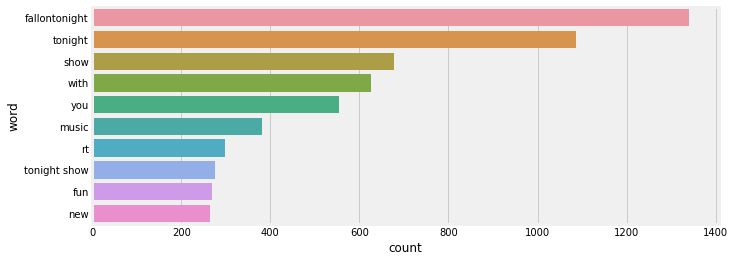

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
%matplotlib inline

figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(10, 4)

sns.barplot(data=dictionary_df[:10], y="word", x="count", ax=ax)

#### 3.3) Wordcloud Visualization 
- Display most used words in **@jimmyfallon tweets**

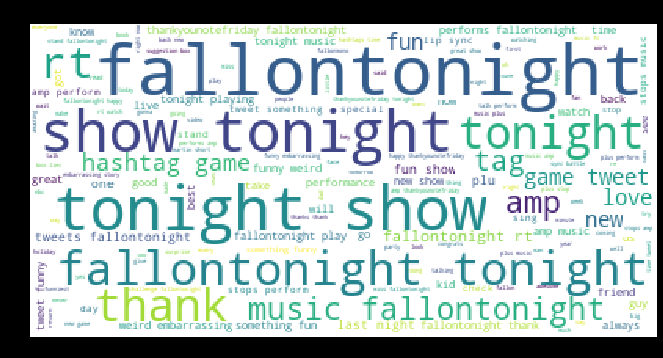

In [207]:
#from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 2016).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(10,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Wordcloud")

    
wordcloud(tweets,'text')  

#### 3.4) Team 5 Findings - Word Frequency:
- **@jimmyfallon** mainly promotes his show on Twitter 


---

### 4) Sentiment Analysis

#### 4.1) Assign sentiment values: 
- Score each Tweet using sentiment_analyzer.polarity_scores()
- Assign each score a sentiment id based on range 

In [208]:
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
#nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [209]:
sentiment_analyzer = SentimentIntensityAnalyzer()

In [210]:
tweets['text_lem'] = [''.join([WordNetLemmatizer().lemmatize(re.sub('[^A-Za-z]', ' ', line)) for line in lists]).strip() for lists in tweets['text']] 
vectorizer = TfidfVectorizer(max_df=0.5,max_features=10000,min_df=10,stop_words='english',use_idf=True)
X = vectorizer.fit_transform(tweets['text'].str.upper())


In [211]:
tweets['sentiment_compound_polarity']=tweets.text_lem.apply(lambda x:sentiment_analyzer.polarity_scores(x)['compound'])
tweets['sentiment_neutral']=tweets.text_lem.apply(lambda x:sentiment_analyzer.polarity_scores(x)['neu'])
tweets['sentiment_negative']=tweets.text_lem.apply(lambda x:sentiment_analyzer.polarity_scores(x)['neg'])
tweets['sentiment_pos']=tweets.text_lem.apply(lambda x:sentiment_analyzer.polarity_scores(x)['pos'])
tweets['sentiment_type']=''

tweets.loc[tweets.sentiment_compound_polarity>0,'sentiment_type']='POSITIVE'
tweets.loc[tweets.sentiment_compound_polarity==0,'sentiment_type']='NEUTRAL'
tweets.loc[tweets.sentiment_compound_polarity<0,'sentiment_type']='NEGATIVE'

In [212]:
tweets.head(1)

,TimeStamp,Name,text,lang,tweet_id,Favorites,Retweet,in_reply_to_status_id_str,in_reply_to_screen_name,tweetos,text_original,text_lem,sentiment_compound_polarity,sentiment_neutral,sentiment_negative,sentiment_pos,sentiment_type
0,Tue Jul 17 01:54:48 +0000 2018,jimmyfallon,rt great way to start a week of new shows with...,en,1019037671295979520,0,92,None,None,other,rt great way to start a week of new shows with...,rt great way to start a week of new shows with...,0.6249,0.773,0.0,0.227,POSITIVE


#### 4.2) Summarize the Sentiment Data

-  Count of tweets, average favorites, and average retweets
-  Display the most positive/most negative Tweet 
-  Bar/pie chart displaying the tweet sentiment by sentiment id 

In [221]:
calcs = {'sentiment_type': 'count', 
         'Favorites': 'mean',
         'Retweet': 'mean'}
tweets.groupby(['sentiment_type']).agg(calcs).sort_values(['sentiment_type'], ascending = False)

,sentiment_type,Retweet,Favorites
sentiment_type,,,
POSITIVE,1736,843.044931,3075.373848
NEUTRAL,1034,790.825919,2604.858801
NEGATIVE,452,1106.037611,2748.402655


In [222]:
#most positive/ most negative tweets
sentiment = tweets.sort_values(['sentiment_compound_polarity'], ascending = False).reset_index()
most_positive = sentiment .iloc[0]
most_negative = sentiment .iloc[(len(sentiment)-1)]

In [223]:
most_positive

index                                                                       2319
TimeStamp                                         Fri Nov 27 00:57:38 +0000 2015
Name                                                                 jimmyfallon
text                           thanks thanks thanks thanks thanks thanks than...
lang                                                                          en
tweet_id                                                      670043770113495041
Favorites                                                                  18753
Retweet                                                                     7849
in_reply_to_status_id_str                                                   None
in_reply_to_screen_name                                                     None
tweetos                                                                    other
text_original                  thanks thanks thanks thanks thanks thanks than...
text_lem                    

In [224]:
most_negative

index                                                                        241
TimeStamp                                         Thu Apr 26 04:29:24 +0000 2018
Name                                                                 jimmyfallon
text                           nono no no no no no no no no no no no no it’s ...
lang                                                                          it
tweet_id                                                      989360772739461120
Favorites                                                                    646
Retweet                                                                       69
in_reply_to_status_id_str                                                   None
in_reply_to_screen_name                                                     None
tweetos                                                                    other
text_original                  nono no no no no no no no no no no no no it’s ...
text_lem                    

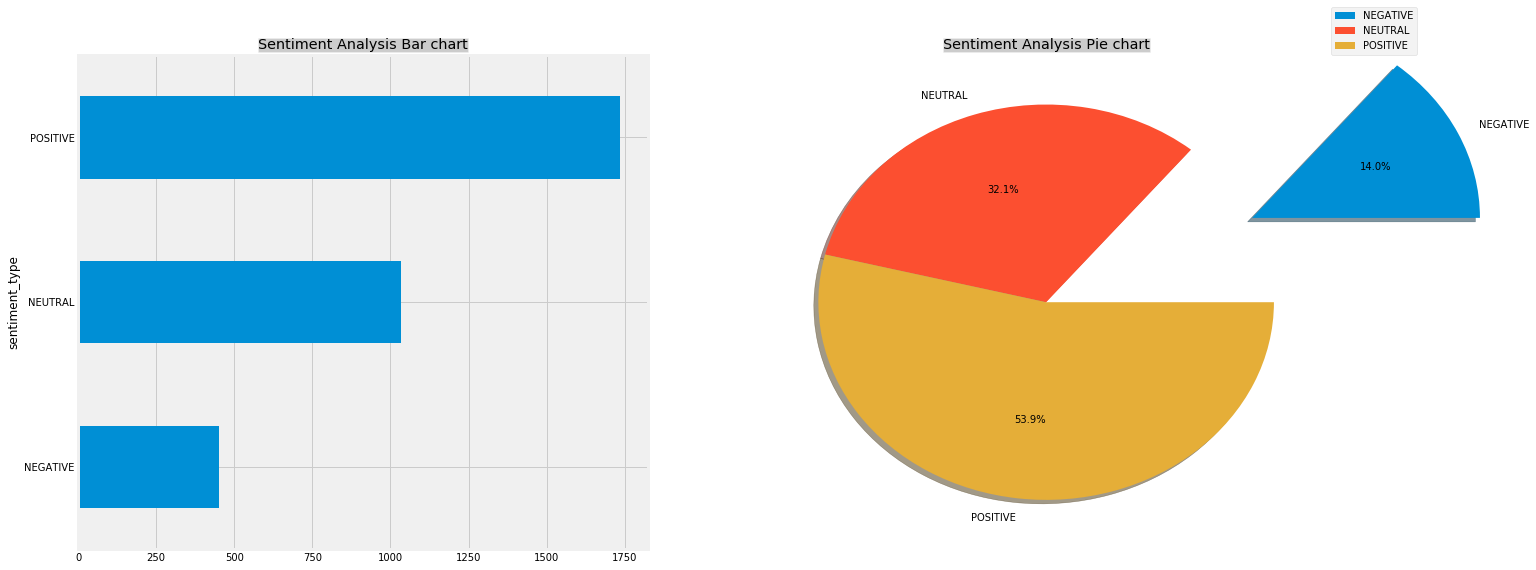

In [225]:
#Visualize sentiments
tweets_sentiment = tweets.groupby(['sentiment_type'])['sentiment_neutral'].count()
tweets_sentiment.rename("",inplace=True)
explode = (1, 0, 0)
plt.subplot(221)
tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
plt.title('Sentiment Analysis Bar chart', bbox={'facecolor':'0.8', 'pad':0})
plt.subplot(222)
tweets_sentiment.plot(kind='pie',figsize=(20, 20),autopct='%1.1f%%',shadow=True,explode=explode)
plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
plt.title('Sentiment Analysis Pie chart', bbox={'facecolor':'0.8', 'pad':0})
plt.show()

#### 4.2) Team 5 Findings - Sentiment Analysis:
-  Over 50% of **@jimmyfallon** tweets were positive
    - Since most of the tweets were either positive or neutral, Team 5 confirmed its positive tweet hypothesis  
    
-  Negative tweets were retweeted more often, on average

  - Given that the majority of tweets were positive, it is surprising that **@jimmyfallon** Twitter followers were more likely to retweet a negative tweet. 
  
-  Positive tweets are favored more often, on average



---

### 6) Network Analysis

    6.1) Gather the data using api.friends_ids() & api.get_user()
    6.2) Explore the relationship between twitter accounts
    6.3) A weight value should be total number of followers for the first twitter account.

In [227]:
friend_ids = api.friends_ids(screen_name="jimmyfallon")
keys = []
values = []

for x in friend_ids[:200]:
    keys.append(x)
    profiles = api.get_user(id = x)
    values.append(jsonpickle.encode(profiles._json, unpicklable=False))


In [233]:
temp_tweets_data = []
for line in values:
    try:
        temp_tweet = json.loads(line)
        temp_tweets_data.append(temp_tweet)
    except:
        continue

In [240]:
len(temp_tweets_data)

200

---

# Sources

http://adilmoujahid.com/posts/2014/07/twitter-analytics/

https://media.readthedocs.org/pdf/tweepy/latest/tweepy.pdf

https://www.karambelkar.info/2015/01/how-to-use-twitters-search-rest-api-most-effectively./

https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html
